In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [ ]:
# Load the data
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated")
def load_training_data(interpolated_dir, test = [2023]):
    training_data = {}
    for folder in os.listdir(interpolated_dir):
        folder_path = os.path.join(interpolated_dir, folder)
        print(f"Loading data for {folder}")
        if os.path.isdir(folder_path):
            if not(int(folder) in test):
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        for _, row in df.iloc[1:].iterrows():
                            row["relative_strength"] = df.iloc[0]["homeWinProbability"]
                            row["away_team_id"] = df.iloc[0]["away_team_id"]
                            row["home_team_id"] = df.iloc[0]["home_team_id"]
                            row["home_win"] = df.iloc[0]["home_win"]
                            if row["timestep"] not in training_data:
                                training_data[row["timestep"]] = [row] 
                            else:
                                training_data[row["timestep"]] += [row]
            else: 
                print("skipping ", folder)
    return training_data

training_data= load_training_data(interpolated_dir)

Loading data for 2022
Loaded data for 2022
Loading data for 2023
Loaded data for 2023
Loading data for .DS_Store
Loaded data for .DS_Store
Loading data for 2019
Loaded data for 2019
Loading data for 2021
Loaded data for 2021
Loading data for 2020
Loaded data for 2020


In [ ]:
# Get information about the data
for timestep in training_data:
    print(f"timestep: {timestep}, number of instances: {len(training_data[timestep])}")

timestep: 0.0, number of instances: 2096
timestep: 0.005, number of instances: 1512
timestep: 0.01, number of instances: 1377
timestep: 0.015, number of instances: 1519
timestep: 0.02, number of instances: 1439
timestep: 0.025, number of instances: 1544
timestep: 0.03, number of instances: 1530
timestep: 0.035, number of instances: 1523
timestep: 0.04, number of instances: 1548
timestep: 0.045, number of instances: 1522
timestep: 0.05, number of instances: 1572
timestep: 0.055, number of instances: 1569
timestep: 0.06, number of instances: 1578
timestep: 0.065, number of instances: 1603
timestep: 0.07, number of instances: 1577
timestep: 0.075, number of instances: 1611
timestep: 0.08, number of instances: 1616
timestep: 0.085, number of instances: 1573
timestep: 0.09, number of instances: 1627
timestep: 0.095, number of instances: 1621
timestep: 0.1, number of instances: 1642
timestep: 0.105, number of instances: 1606
timestep: 0.11, number of instances: 1633
timestep: 0.115, number o

In [ ]:
features = ["home_win", "relative_strength", "homeScore", "awayScore", "scoringPlay", "start.down", "start.distance", "start.yardLine", "end.down", "end.distance", "end.yardLine"]
for timestep in training_data.keys():
    # Find rows that have NaN values for my array of features
    rows = training_data[timestep]
    # Get all rows such that one of the features is NaN
    rows_with_nan = [row for row in rows if any(np.isnan(row[feature]) for feature in features)]
    # Print row with NaN values + timestep
    if len(rows_with_nan) > 0:
        print("Timestep:", timestep)
        for row in rows_with_nan:
            print(row)

In [ ]:
# Feature Selection
def feature_selection(data, features):
    # Given the features of the data, return data such that each row is an array of the values of the features
    # The data is a dictionary where the key is the timestep and the value is a list of rows
    feature_data = {}
    for timestep in data:
        feature_data[timestep] = []
        for row in data[timestep]:
            new_row = [[float(row[feature]) for feature in features]]
            # First check if the row has any NaN values
            if any(np.isnan(new_row[0])):
                continue
            feature_data[timestep] += new_row
    return feature_data

features_data = feature_selection(training_data, features)

In [ ]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create an array of logistic regression models
models = {}
def setup_models(features_data):
    for timestep in features_data:
        X = np.array(features_data[timestep])[:,1:]
        y = np.array(features_data[timestep])[:,0]
        model = LogisticRegression(max_iter=1000)
        print("Training for timestep", timestep)
        model.fit(x, y)
        models[timestep] = model


setup_models(features_data)


Training for timestep 0.0
Training for timestep 0.005
Training for timestep 0.01
Training for timestep 0.015
Training for timestep 0.02
Training for timestep 0.025
Training for timestep 0.03
Training for timestep 0.035
Training for timestep 0.04
Training for timestep 0.045
Training for timestep 0.05
Training for timestep 0.055
Training for timestep 0.06
Training for timestep 0.065
Training for timestep 0.07
Training for timestep 0.075
Training for timestep 0.08
Training for timestep 0.085
Training for timestep 0.09
Training for timestep 0.095
Training for timestep 0.1
Training for timestep 0.105
Training for timestep 0.11
Training for timestep 0.115
Training for timestep 0.12
Training for timestep 0.125
Training for timestep 0.13
Training for timestep 0.135
Training for timestep 0.14
Training for timestep 0.145
Training for timestep 0.15
Training for timestep 0.155
Training for timestep 0.16
Training for timestep 0.165
Training for timestep 0.17
Training for timestep 0.175
Training for

In [108]:
def load_test_data(interpolated_dir, test = [2023]):
    test_data = {}
    for folder in os.listdir(interpolated_dir):
        folder_path = os.path.join(interpolated_dir, folder)
        print(f"Loading data for {folder}")
        if os.path.isdir(folder_path):
            if int(folder) in test:
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        seen_timesteps = set()
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        for _, row in df.iloc[1:].iterrows():
                            row["relative_strength"] = df.iloc[0]["homeWinProbability"]
                            row["away_team_id"] = df.iloc[0]["away_team_id"]
                            row["home_team_id"] = df.iloc[0]["home_team_id"]
                            row["home_win"] = df.iloc[0]["home_win"]
                            if file not in test_data and row["timestep"] not in seen_timesteps:
                                seen_timesteps.add(row["timestep"])
                                test_data[file] = [row] 
                            elif row["timestep"] not in seen_timesteps:
                                seen_timesteps.add(row["timestep"]) 
                                test_data[file] += [row]
    return test_data
test_data = load_test_data(interpolated_dir)
for timestep in test_data:
    print(f"timestep: {timestep}, number of instances: {len(test_data[timestep])}")
print(test_data.keys())

Loading data for 2022
Loading data for 2023
Loading data for .DS_Store
Loading data for 2019
Loading data for 2021
Loading data for 2020
timestep: updated_game_401547531.csv, number of instances: 201
timestep: updated_game_401547525.csv, number of instances: 201
timestep: updated_game_401547519.csv, number of instances: 201
timestep: updated_game_401547647.csv, number of instances: 201
timestep: updated_game_401547653.csv, number of instances: 201
timestep: updated_game_401547486.csv, number of instances: 201
timestep: updated_game_401547492.csv, number of instances: 201
timestep: updated_game_401547445.csv, number of instances: 201
timestep: updated_game_401547451.csv, number of instances: 201
timestep: updated_game_401547479.csv, number of instances: 201
timestep: updated_game_401547478.csv, number of instances: 201
timestep: updated_game_401547450.csv, number of instances: 201
timestep: updated_game_401547444.csv, number of instances: 201
timestep: updated_game_401547493.csv, number

In [109]:
def test_feature_selection(data, features):
    # Given the features of the data, return data such that each row is an array of the values of the features
    # The data is a dictionary where the key is the timestep and the value is a list of rows
    feature_data = {}
    for file in data:
        feature_data[file] = []
        for row in data[file]:
            new_row = [[float(row[feature]) for feature in features]]
            # First check if the row has any NaN values
            if any(np.isnan(new_row[0])):
                continue
            feature_data[file] += new_row
    return feature_data
features_test_data = test_feature_selection(test_data, features)

In [ ]:
len(features_test_data), len(features_test_data['updated_game_401547531.csv'])

(271, 201)

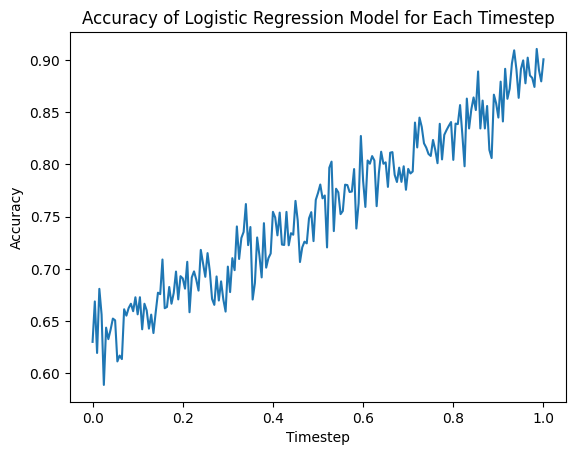

In [ ]:
# Test accuracy of model for each timestep on test data and plot
accuracies = []
timesteps = []
for timestep in models:
    model = models[timestep]
    # MODIFY THIS TO GET TEST DATA
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)
    timesteps.append(timestep)

plt.plot(timesteps, accuracies)
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.title("Accuracy of Logistic Regression Model for Each Timestep")
plt.show()

In [111]:
for file in features_test_data:
    print(file)
    for i, timestep in zip(range(len(models)), models):
        model = models[timestep]
        X_test = np.array(features_test_data[file][i])[1:].reshape(1, -1)
        y_test = np.array(features_test_data[file][i])[0].reshape(1, -1)
        pred = model.predict_proba(X_test)
        print(f"Prediction for timestep {timestep} in {file}: {pred}")
        

updated_game_401547531.csv
Prediction for timestep 0.0 in updated_game_401547531.csv: [[0.32737875 0.67262125]]
Prediction for timestep 0.005 in updated_game_401547531.csv: [[0.32774233 0.67225767]]
Prediction for timestep 0.01 in updated_game_401547531.csv: [[0.31370987 0.68629013]]
Prediction for timestep 0.015 in updated_game_401547531.csv: [[0.67584871 0.32415129]]
Prediction for timestep 0.02 in updated_game_401547531.csv: [[0.41967535 0.58032465]]
Prediction for timestep 0.025 in updated_game_401547531.csv: [[0.26568574 0.73431426]]
Prediction for timestep 0.03 in updated_game_401547531.csv: [[0.41904419 0.58095581]]
Prediction for timestep 0.035 in updated_game_401547531.csv: [[0.31166544 0.68833456]]
Prediction for timestep 0.04 in updated_game_401547531.csv: [[0.29263165 0.70736835]]
Prediction for timestep 0.045 in updated_game_401547531.csv: [[0.27757228 0.72242772]]
Prediction for timestep 0.05 in updated_game_401547531.csv: [[0.25548592 0.74451408]]
Prediction for timestep

IndexError: list index out of range

In [91]:
model = models[1.0]
model.predict_proba([[0.7006, 31.0, 30.0, 0.0, 4.0, 5.0, 22.0, 4.0, 5.0, 22.0]])

array([[0.46622128, 0.53377872]])

In [85]:
features_test_data['updated_game_401547531.csv']

[[0.0, 0.7006, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 1.0, 10.0, 75.0],
 [0.0, 0.7006, 0.0, 0.0, 0.0, 1.0, 10.0, 75.0, 2.0, 10.0, 71.0],
 [0.0, 0.7006, 0.0, 0.0, 0.0, 1.0, 10.0, 75.0, 2.0, 10.0, 71.0],
 [0.0, 0.7006, 7.0, 0.0, 1.0, 2.0, 6.0, 71.0, -1.0, 10.0, 100.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.0, 10.0, 75.0, 1.0, 10.0, 62.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.0, 10.0, 62.0, 2.0, 11.0, 63.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 2.0, 11.0, 63.0, 3.0, 10.0, 63.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 3.0, 11.0, 63.0, 4.0, 2.0, 63.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.0, 10.0, 21.0, 1.0, 10.0, 21.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.0, 10.0, 21.0, 2.0, 6.0, 29.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 2.0, 2.0, 29.0, 1.0, 10.0, 34.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.0, 10.0, 34.0, 2.0, 10.0, 39.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 2.0, 5.0, 39.0, 1.0, 6.0, 57.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 2.0, 5.0, 39.0, 1.0, 6.0, 57.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.0, 10.0, 57.0, 2.0, 10.0, 61.0],
 [0.0, 0.7006, 7.0, 0.0, 0.0, 1.

In [119]:
for folder in os.listdir(interpolated_dir):
    if not os.path.isdir(os.path.join(interpolated_dir, folder)):
        continue
    print(folder)
    for file in os.listdir(os.path.join(interpolated_dir, folder)):
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(interpolated_dir, folder, file))
            # check if data.iloc[1]["homeScore"] is NaN
            if pd.isna(data.iloc[1]["homeScore"]) or pd.isna(data.iloc[1]["awayScore"]):
                print(file)

2022
2023
updated_game_401547520.csv
updated_game_401547590.csv
updated_game_401547626.csv
updated_game_401547608.csv
updated_game_401547228.csv
updated_game_401547459.csv
2019
2021
2020
